In [1]:
import glob, os
import torch
from torch.nn import *
import torchvision
from torchvision.datasets import GTSRB

In [2]:
from torchvision import transforms as T

mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose( [T.Resize((im_size, im_size)),
                  T.ToTensor(),
                  T.Normalize(mean = mean,
                              std = std)] )



# Train and val ds
ds = GTSRB(root = "Datasets", split = "train",  transform = tfs, download = True)

# Test ds
ts_ds = GTSRB(root = "Datasets", split = "test", transform = tfs, download = True)


In [27]:
# num_classes = ds.labels  # ds is your GTSRB dataset
# print(f"Number of classes: {num_classes}")

In [4]:
labels = [label for _, label in ds]
num_classes = len(set(labels))
print(f"Number of classes: {num_classes}")

Number of classes: 43


In [5]:


if num_classes > 2: print(f"Multiclass classification.\nThere are {num_classes} classes in the dataset")
elif num_classes == 2: print("Binary classification")
else: "It is not a classifcation"
print(f"There are total {len(ds)+ len(ts_ds)} images")

Multiclass classification.
There are 43 classes in the dataset
There are total 39270 images


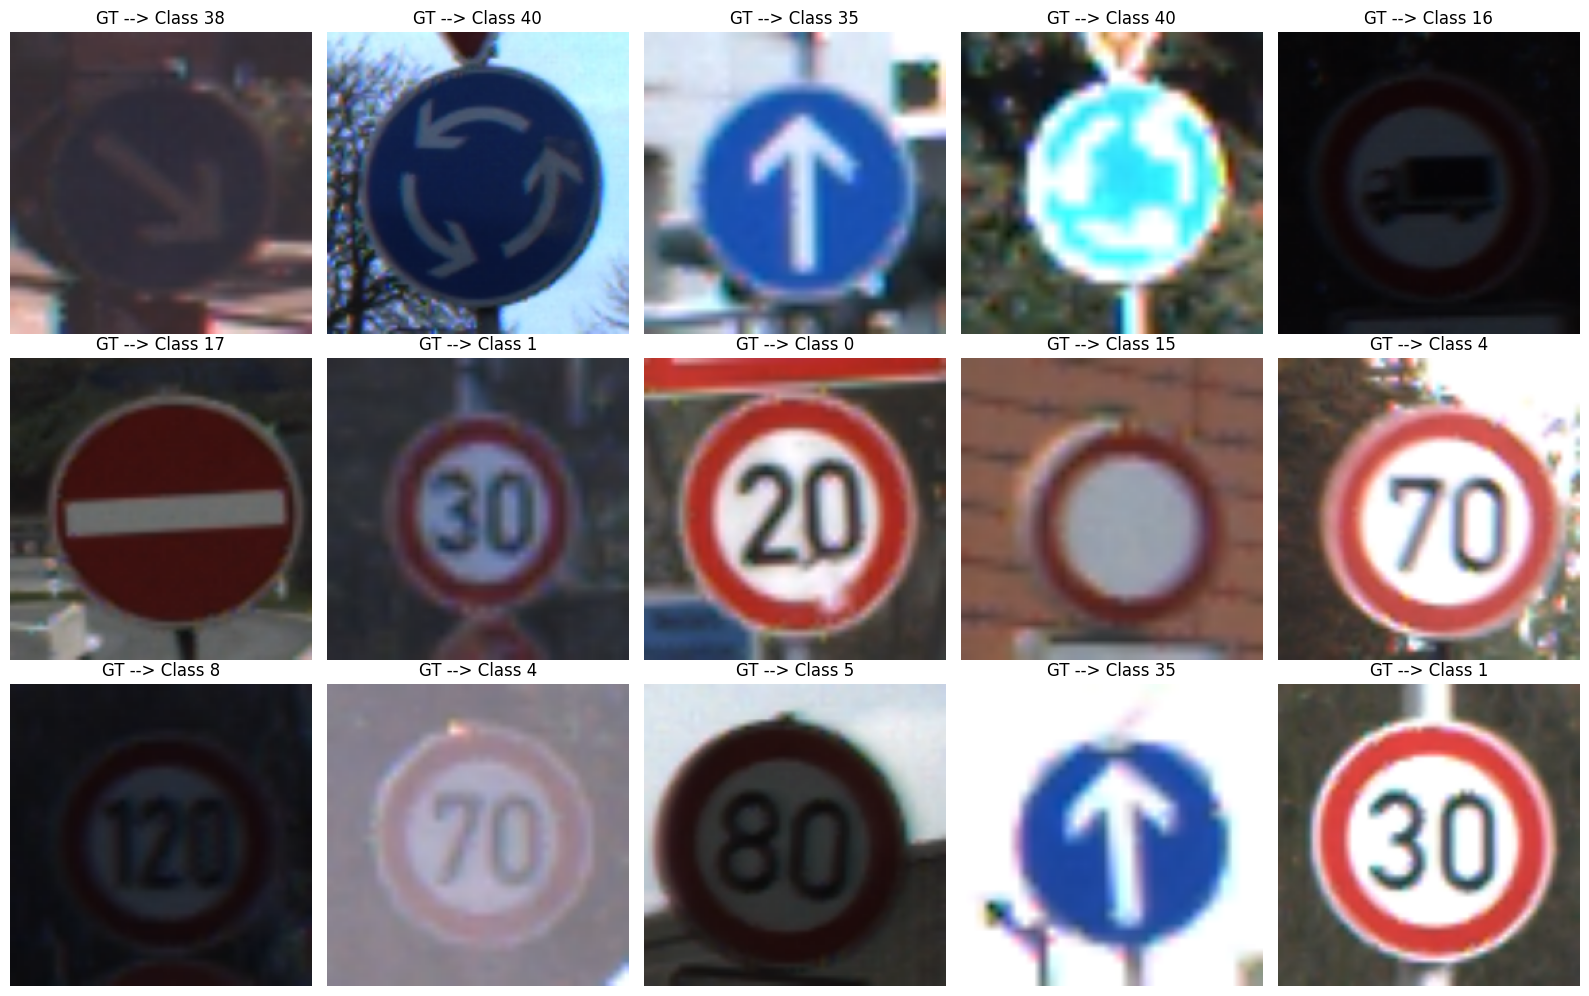

In [6]:
import random
import matplotlib.pyplot as plt
import torch

def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

def random_visual(dataset, class_names, num_images=20, cols=5):
    rows = (num_images + cols - 1) // cols
    indices = random.sample(range(len(dataset)), num_images)
    plt.figure(figsize=(16, 10))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        label = int(label)

        if isinstance(image, torch.Tensor):
            image = unnormalize(image)
            image = image.permute(1, 2, 0).numpy()
            image = (image * 255).astype("uint8")

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f"GT --> {class_names[label]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Fix: create class name mapping manually
unique_labels = sorted(set([label for _, label in ds]))
class_names = {i: f"Class {i}" for i in unique_labels}

random_visual(ds, class_names, num_images=15, cols=5)

In [7]:
# PyTorch DataLoader
from torch.utils.data  import random_split, DataLoader

total_len = len(ds)
tr_len = int(total_len * 0.8)
vl_len = total_len - tr_len

tr_len, vl_len

(21312, 5328)

In [8]:
tr_ds, vl_ds = random_split(dataset = ds, lengths=[tr_len, vl_len]); print(len(tr_ds), len(vl_ds))

21312 5328


In [9]:
bs = 128  # mini batch
tr_dl = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 2)
vl_dl = DataLoader(dataset = vl_ds, batch_size = bs, shuffle = False, num_workers = 2)
ts_dl = DataLoader(dataset = ts_ds, batch_size = 1, shuffle = False, num_workers = 2)

## Data analysis

In [10]:
train_labels = [label for _, label in tr_ds]
val_labels   = [label for _, label in vl_ds]
test_labels  = [label for _, label in ts_ds]

all_labels = train_labels + val_labels + test_labels
num_classes = len(set(all_labels))

# Create class names dictionary like {0: 'Class 1', 1: 'Class 2', ...}
cls_names = {i: f"Class {i+1}" for i in range(num_classes)}

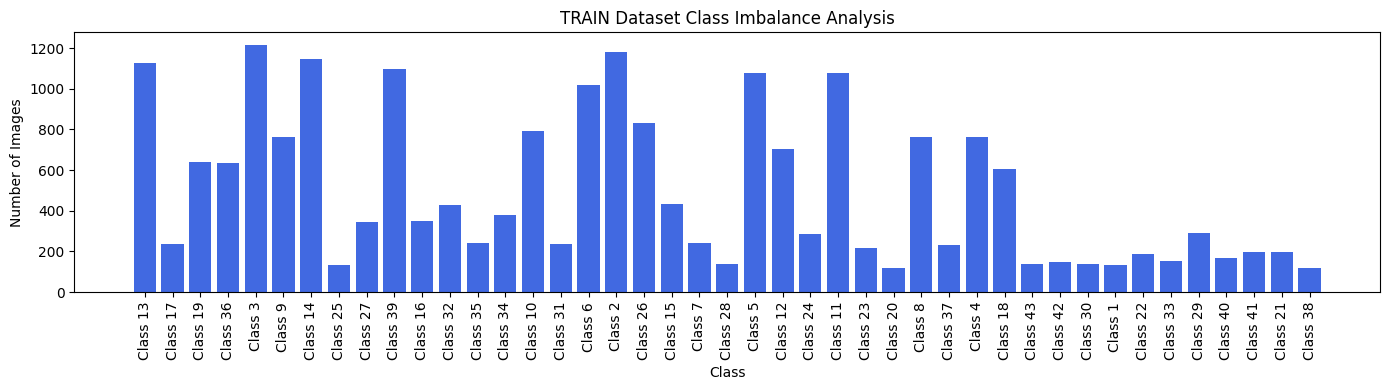

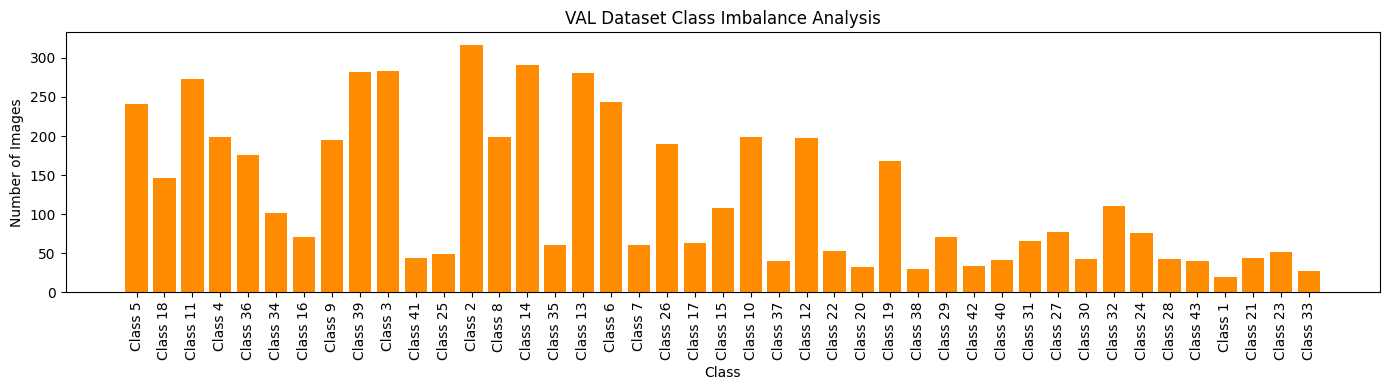

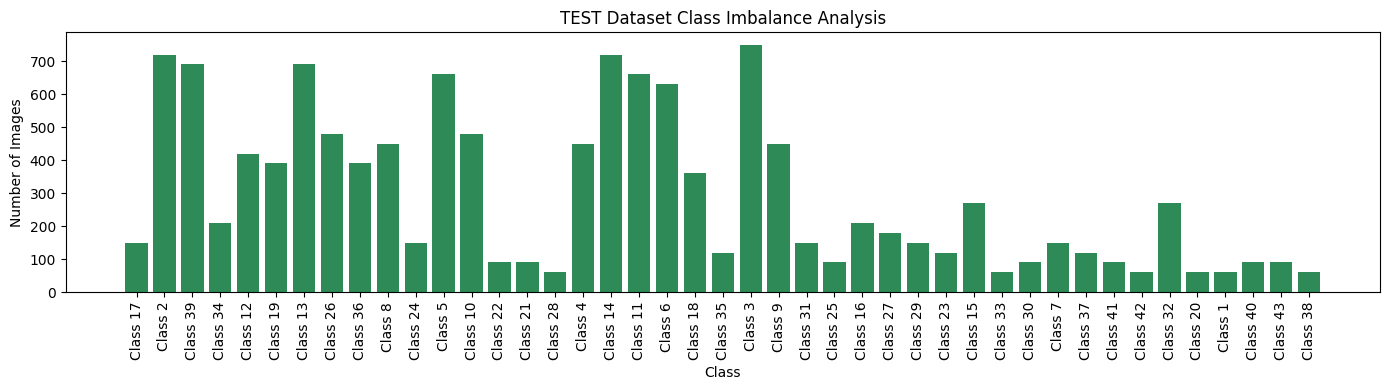

Train dataset - max: 1217, min: 118, mean: 495.63, std: 365.99
Validation dataset - max: 317, min: 19, mean: 123.91, std: 91.87
Test dataset - max: 750, min: 60, mean: 293.72, std: 230.71


In [11]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


# Count labels for each subset
train_labels = [label for _, label in tr_ds]
val_labels   = [label for _, label in vl_ds]
test_labels  = [label for _, label in ts_ds]

# Count frequency
train_count = Counter(train_labels)
val_count   = Counter(val_labels)
test_count  = Counter(test_labels)

# Convert label indexes to class names
train_class_count = {cls_names[k]: v for k, v in train_count.items()}
val_class_count   = {cls_names[k]: v for k, v in val_count.items()}
test_class_count  = {cls_names[k]: v for k, v in test_count.items()}

# Updated plotting function with color argument
def plot_distribution(class_count, title, color):
    plt.figure(figsize=(14, 4))
    plt.bar(class_count.keys(), class_count.values(), color=color)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

# Plot each dataset with a different color
plot_distribution(train_class_count, "TRAIN Dataset Class Imbalance Analysis", color="royalblue")
plot_distribution(val_class_count,   "VAL Dataset Class Imbalance Analysis",   color="darkorange")
plot_distribution(test_class_count,  "TEST Dataset Class Imbalance Analysis",  color="seagreen")

# Imbalance stats
def print_imbalance_stats(counts, name):
    values = list(counts.values())
    print(f"{name} dataset - max: {max(values)}, min: {min(values)}, mean: {np.mean(values):.2f}, std: {np.std(values):.2f}")

print_imbalance_stats(train_class_count, "Train")
print_imbalance_stats(val_class_count, "Validation")
print_imbalance_stats(test_class_count, "Test")

In [12]:
def plot_pie_chart(class_count, title):
    labels = list(class_count.keys())
    sizes = list(class_count.values())

    plt.figure(figsize=(12, 12))
    plt.pie(sizes, labels=labels, startangle=90, counterclock=False, wedgeprops=dict(width=0.4), autopct='%1.1f%%')
    plt.title(title)
    plt.tight_layout()
    plt.show()

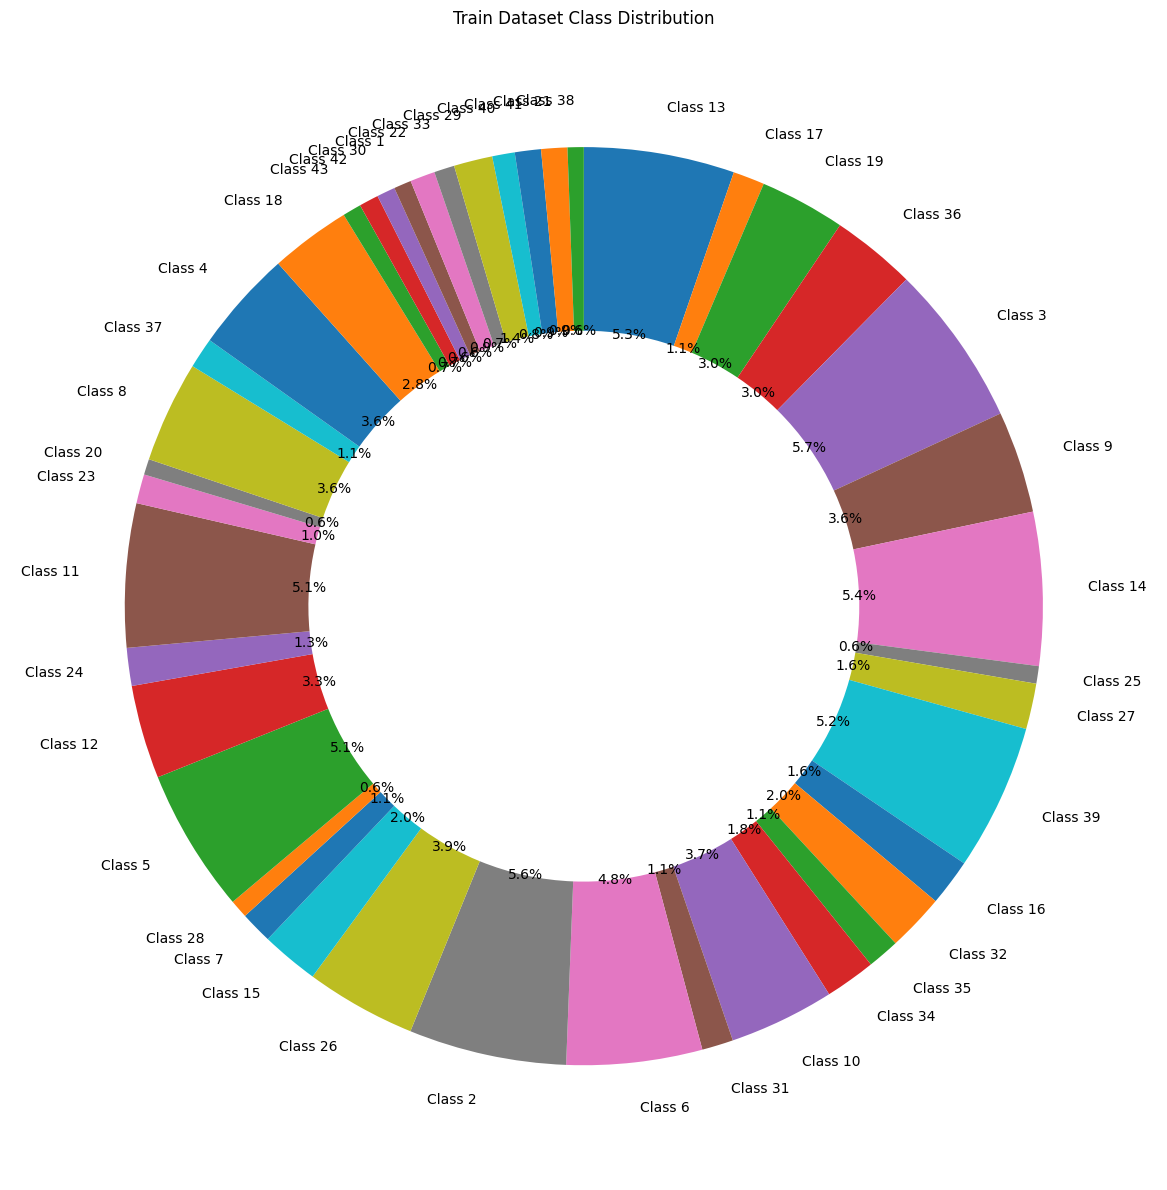

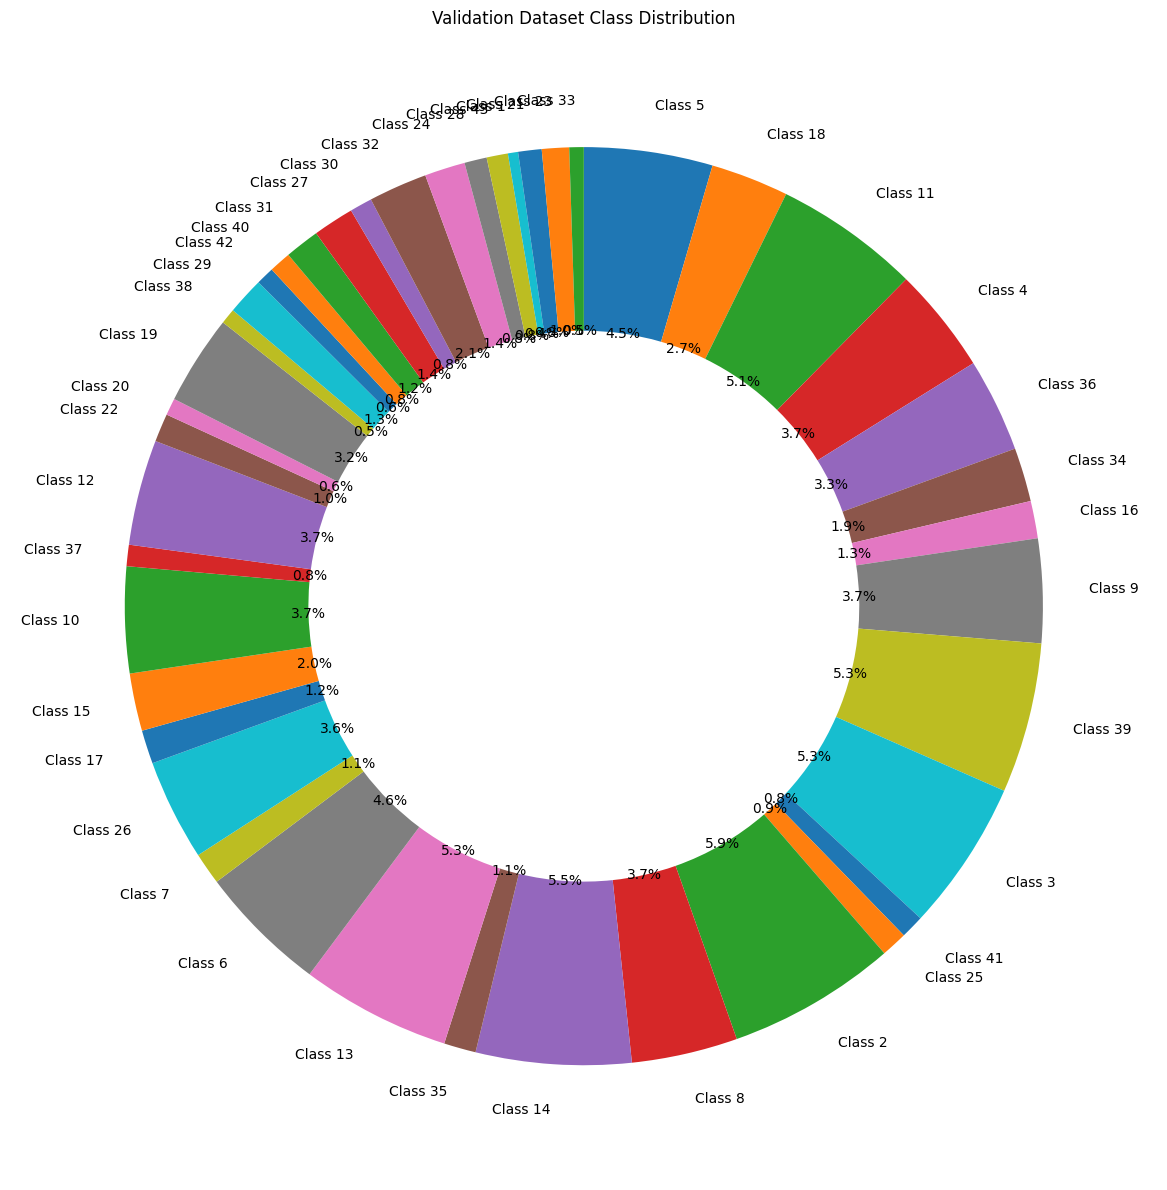

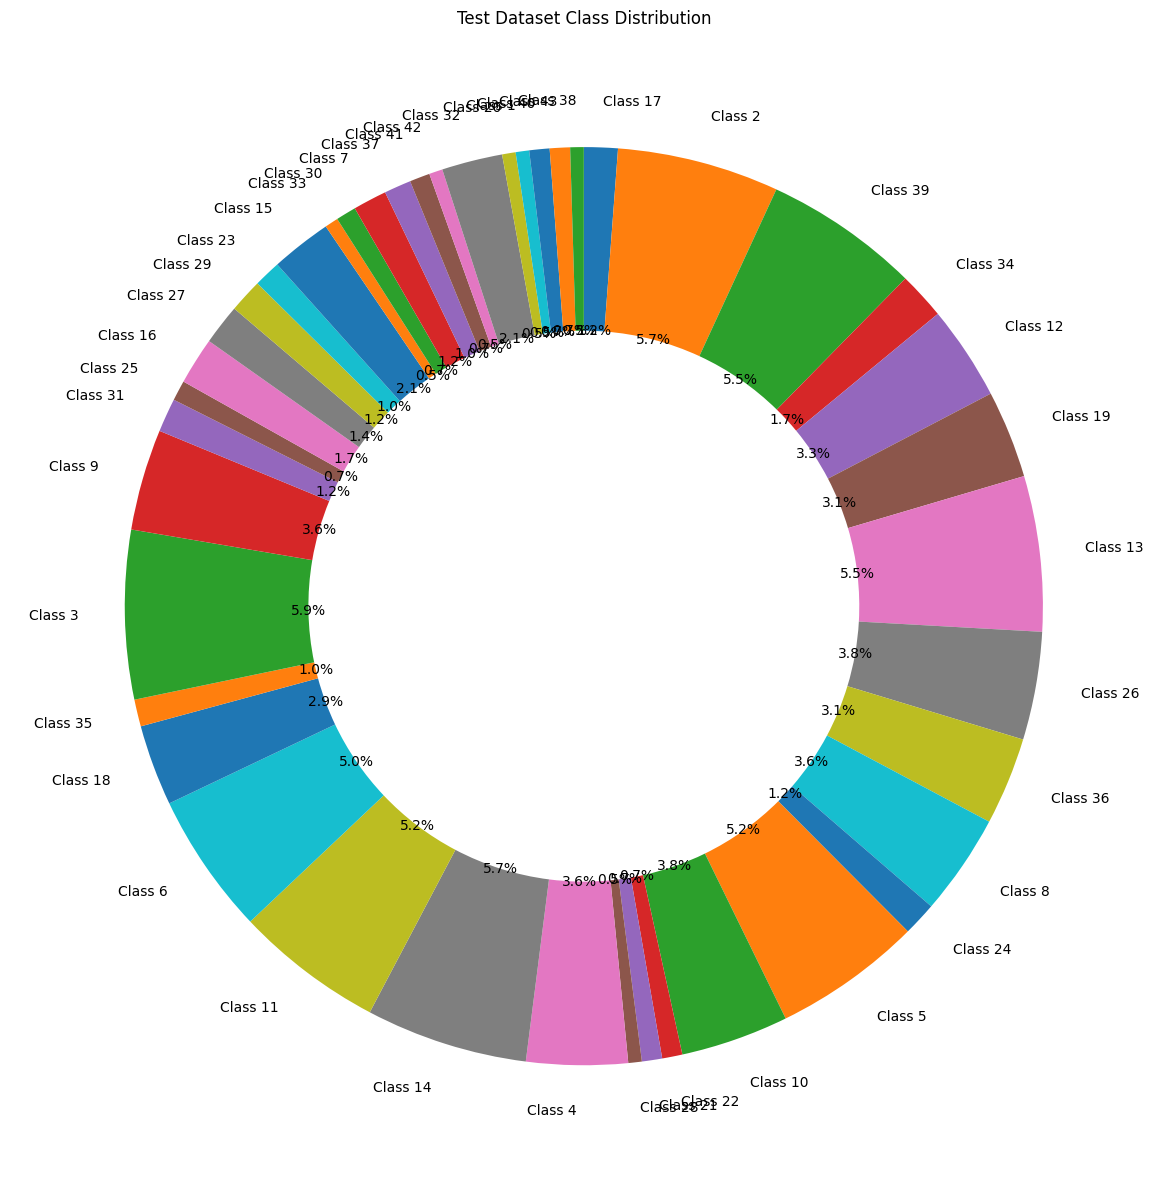

In [13]:
plot_pie_chart(train_class_count, "Train Dataset Class Distribution")
plot_pie_chart(val_class_count, "Validation Dataset Class Distribution")
plot_pie_chart(test_class_count, "Test Dataset Class Distribution")

## AI Model

In [14]:
import torch.nn.functional as F

class CustomModel(Module):
    def __init__(self, num_cls):
        super(CustomModel, self).__init__()


        # Conv block - 1
        self.conv1 = Sequential(
            Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
            ReLU(),
            BatchNorm2d(32),
            MaxPool2d(kernel_size = 2, stride = 2)
        )

        # Conv block - 2
        self.conv2 = Sequential(
            Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
            ReLU(),
            BatchNorm2d(64),
            MaxPool2d(kernel_size = 2, stride = 2)

        )

        # Conv block - 3
        self.conv3 = Sequential(
            Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1),
            ReLU(),
            BatchNorm2d(128),
            MaxPool2d(kernel_size = 2, stride = 2)

        )

        # Conv block - 3
        self.conv4 = Sequential(
            Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            ReLU(),
            BatchNorm2d(256),
            MaxPool2d(kernel_size = 2, stride = 2)

        )

        self.fc1 = Linear(256 * 14 * 14, 128)
        self.fc2 = Linear(128, num_cls)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x




In [15]:
model = CustomModel(num_cls=num_classes)
print(model)

CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU

In [16]:
print(num_classes)

43


In [17]:
! pip install torchmetrics

## AI Model Train and Validation

In [18]:
import os, torchmetrics
import timm
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

class TrainValidation:
    def __init__(self, model_name, classes, tr_dl, val_dl, device, save_dir="saved_models", save_prefix="model", lr=3e-4, epochs=25, patience=5, scheduler_patience = 2, threshold=0.01, dev_mode = False):
        # timm create_model
        self.model_name = model_name
        # klass nomlari
        self.classes = classes
        # DLs
        self.tr_dl = tr_dl
        self.val_dl = val_dl

        self.device = device
        # modelni save qilish
        self.save_dir = save_dir
        # cifar; mnist; ants_bees; best_model; cifar_best_model; mnist_best_model
        self.save_prefix = save_prefix
        self.lr = lr
        self.epochs = epochs

        # EarlyStopping
        self.patience = patience
        self.threshold = threshold

        # developer mode;
        self.dev_mode = dev_mode
        # device
        self.device = device

        self.model = timm.create_model(model_name, pretrained=True, num_classes=len(classes)).to(self.device)
        # self.model = CustomModel()).to(self.device)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.f1_metric = torchmetrics.F1Score(task="multiclass", num_classes=len(classes)).to(self.device)
        self.scheduler = ReduceLROnPlateau(optimizer = self.optimizer, mode='min', factor=0.1, patience=scheduler_patience, threshold=0.0001, verbose = True)

        os.makedirs(save_dir, exist_ok=True)

        self.best_loss = float("inf")
        self.best_acc = 0
        self.not_improved = 0

        self.tr_losses, self.val_losses = [], []
        self.tr_accs, self.val_accs = [], []
        self.tr_f1s, self.val_f1s = [], []

    @staticmethod
    def to_device(batch, device):
        ims, gts = batch
        return ims.to(device), gts.to(device)

    def train_epoch(self):
        self.model.train()
        train_loss, train_acc = 0.0, 0.0
        self.f1_metric.reset()

        for idx, batch in tqdm(enumerate(self.tr_dl), desc="Training"):
            # runs only one batch
            if self.dev_mode:
                if idx == 1: break

            ims, gts = TrainValidation.to_device(batch = batch, device = self.device)
            # ims, gts = self.to_device((ims, gts))

            # Forward pass
            preds = self.model(ims)
            loss = self.loss_fn(preds, gts)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update metrics
            train_loss += loss.item() # tensor -> int
            train_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
            self.f1_metric.update(preds, gts)

        train_loss /= len(self.tr_dl)
        train_acc /= len(self.tr_dl.dataset)
        train_f1 = self.f1_metric.compute().item()

        self.tr_losses.append(train_loss)
        self.tr_accs.append(train_acc)
        self.tr_f1s.append(train_f1)

        return train_loss, train_acc, train_f1

    def validate_epoch(self):
        self.model.eval()
        val_loss, val_acc = 0.0, 0.0
        self.f1_metric.reset()

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(self.val_dl), desc="Validation"):
                # runs only one batch
                if self.dev_mode:
                    if idx == 1: break
                # ims, gts = self.to_device((ims, gts))
                ims, gts = TrainValidation.to_device(batch, device = self.device)
                preds = self.model(ims)
                loss = self.loss_fn(preds, gts)

                # Update metrics
                val_loss += loss.item()
                val_acc += (torch.argmax(preds, dim=1) == gts).sum().item()
                self.f1_metric.update(preds, gts)

        val_loss /= len(self.val_dl)
        val_acc /= len(self.val_dl.dataset)
        val_f1 = self.f1_metric.compute().item()

        self.val_losses.append(val_loss)
        self.val_accs.append(val_acc)
        self.val_f1s.append(val_f1)

        return val_loss, val_acc, val_f1

    def save_best_model(self, val_f1, val_loss):
        if val_f1 > self.best_acc + self.threshold:
            self.best_acc = val_f1
            save_path = os.path.join(self.save_dir, f"{self.save_prefix}_best_model.pth")
            torch.save(self.model.state_dict(), save_path)
            print(f"Best model saved with F1-Score: {self.best_acc:.3f}")
            self.not_improved = 0
        else:
            self.not_improved += 1
            print(f"No improvement for {self.not_improved} epoch(s).")

    def verbose(self, epoch, metric1, metric2, metric3, process = "train"):

        print(f"{epoch + 1}-epoch {process} process is completed!\n")
        print(f"{epoch + 1}-epoch {process} loss          -> {metric1:.3f}")
        print(f"{epoch + 1}-epoch {process} accuracy      -> {metric2:.3f}")
        print(f"{epoch + 1}-epoch {process} f1-score      -> {metric3:.3f}\n")

    def run(self):
        print("Start training...")

        for epoch in range(self.epochs):
            # runs only one epoch
            if self.dev_mode:
                if epoch == 1: break

            print(f"\nEpoch {epoch + 1}/{self.epochs}:\n")

            train_loss, train_acc, train_f1 = self.train_epoch()
            self.verbose(epoch, train_loss, train_acc, train_f1, process = "train")

            val_loss, val_acc, val_f1 = self.validate_epoch()
            self.scheduler.step(val_loss)
            self.verbose(epoch, val_loss, val_acc, val_f1, process = "validation")

            self.save_best_model(val_f1, val_loss)

            if self.not_improved >= self.patience:
                print("Early stopping triggered.")
                break

model_name   = "rexnet_150"
save_prefix  = "GTSRB"
save_dir     = "saved_models"
device       = "cuda" if torch.cuda.is_available() else "cpu"

trainer = TrainValidation(model_name = model_name, device = device,
                          save_prefix = save_prefix, classes = cls_names,
                          patience = 3, tr_dl = tr_dl, val_dl = vl_dl, dev_mode = False)
trainer.run()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Start training...

Epoch 1/25:



Training: 167it [00:34,  4.82it/s]

1-epoch train process is completed!

1-epoch train loss          -> 0.446
1-epoch train accuracy      -> 0.884
1-epoch train f1-score      -> 0.884




Validation: 42it [00:05,  8.30it/s]


1-epoch validation process is completed!

1-epoch validation loss          -> 0.024
1-epoch validation accuracy      -> 0.993
1-epoch validation f1-score      -> 0.993

Best model saved with F1-Score: 0.993

Epoch 2/25:



Training: 167it [00:33,  5.02it/s]

2-epoch train process is completed!

2-epoch train loss          -> 0.009
2-epoch train accuracy      -> 0.998
2-epoch train f1-score      -> 0.998




Validation: 42it [00:05,  8.35it/s]

2-epoch validation process is completed!

2-epoch validation loss          -> 0.015
2-epoch validation accuracy      -> 0.996
2-epoch validation f1-score      -> 0.996

No improvement for 1 epoch(s).

Epoch 3/25:




Training: 167it [00:33,  5.01it/s]

3-epoch train process is completed!

3-epoch train loss          -> 0.004
3-epoch train accuracy      -> 0.999
3-epoch train f1-score      -> 0.999




Validation: 42it [00:05,  8.37it/s]

3-epoch validation process is completed!

3-epoch validation loss          -> 0.022
3-epoch validation accuracy      -> 0.994
3-epoch validation f1-score      -> 0.994

No improvement for 2 epoch(s).

Epoch 4/25:




Training: 167it [00:33,  5.01it/s]

4-epoch train process is completed!

4-epoch train loss          -> 0.005
4-epoch train accuracy      -> 0.999
4-epoch train f1-score      -> 0.999




Validation: 42it [00:04,  8.43it/s]

4-epoch validation process is completed!

4-epoch validation loss          -> 0.012
4-epoch validation accuracy      -> 0.997
4-epoch validation f1-score      -> 0.997

No improvement for 3 epoch(s).
Early stopping triggered.


## Learning Curves

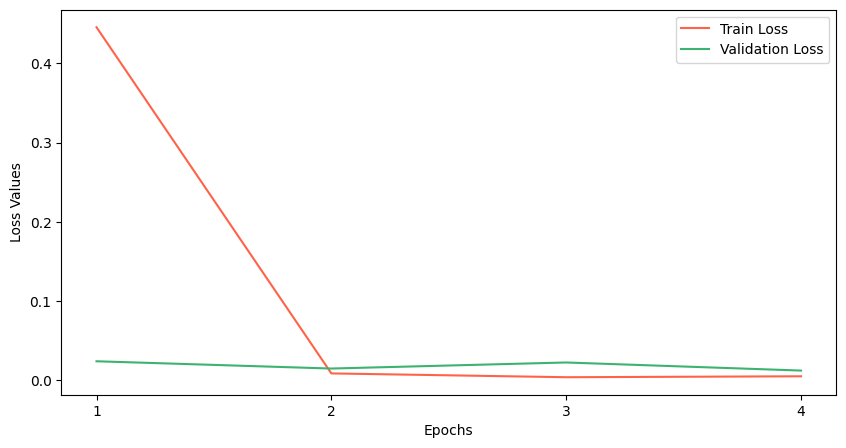

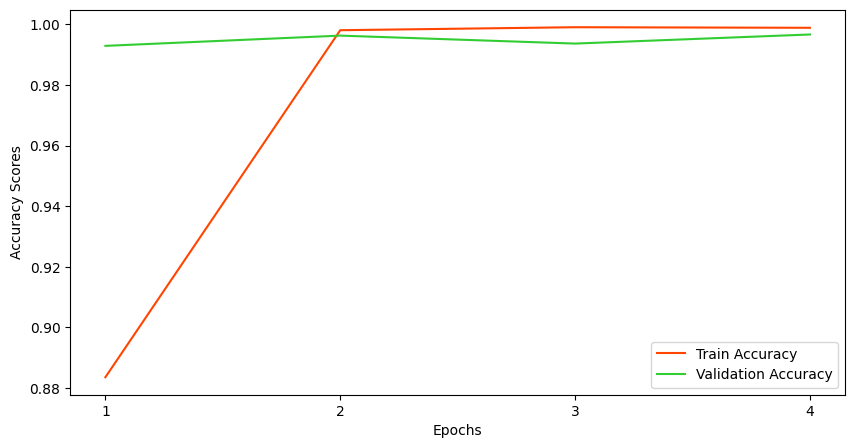

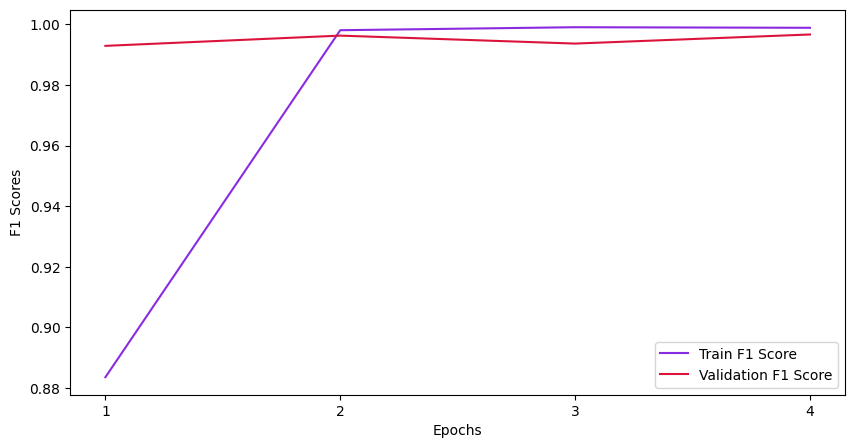

In [19]:
class PlotLearningCurves:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):

        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):

        plt.plot(array_1, label = label_1, c = color_1)
        plt.plot(array_2, label = label_2, c = color_2)

    def create_figure(self):
        plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend()
        plt.show()

    def visualize(self):

        # Figure 1: Loss Curves with more colorful colors
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "#FF6347", color_2 = "#3CB371")  # Tomato and MediumSeaGreen
        self.decorate(ylabel = "Loss Values")

        # Figure 2: Accuracy Curves with more colorful colors
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "#FF4500", color_2 = "#32CD32")  # OrangeRed and LimeGreen
        self.decorate(ylabel = "Accuracy Scores")

        # Figure 3: F1 Score Curves with more colorful colors
        self.create_figure()
        self.plot(array_1 = self.tr_f1s, array_2 = self.val_f1s, label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "#8A2BE2", color_2 = "#DC143C")  # BlueViolet and Crimson
        self.decorate(ylabel = "F1 Scores")

PlotLearningCurves(tr_losses=trainer.tr_losses, val_losses=trainer.val_losses, tr_accs=trainer.tr_accs, val_accs=trainer.val_accs, tr_f1s=trainer.tr_f1s, val_f1s=trainer.val_f1s).visualize()

## GradCam and Confusion Matrix

In [24]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44283 sha256=0d3a65cbc53723e75a123329b148b2036f02c2e1c9bf49b50fe52bfd3610498a
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


Inference: 12630it [02:50, 73.89it/s]


Accuracy of the model on the test data -> 0.953


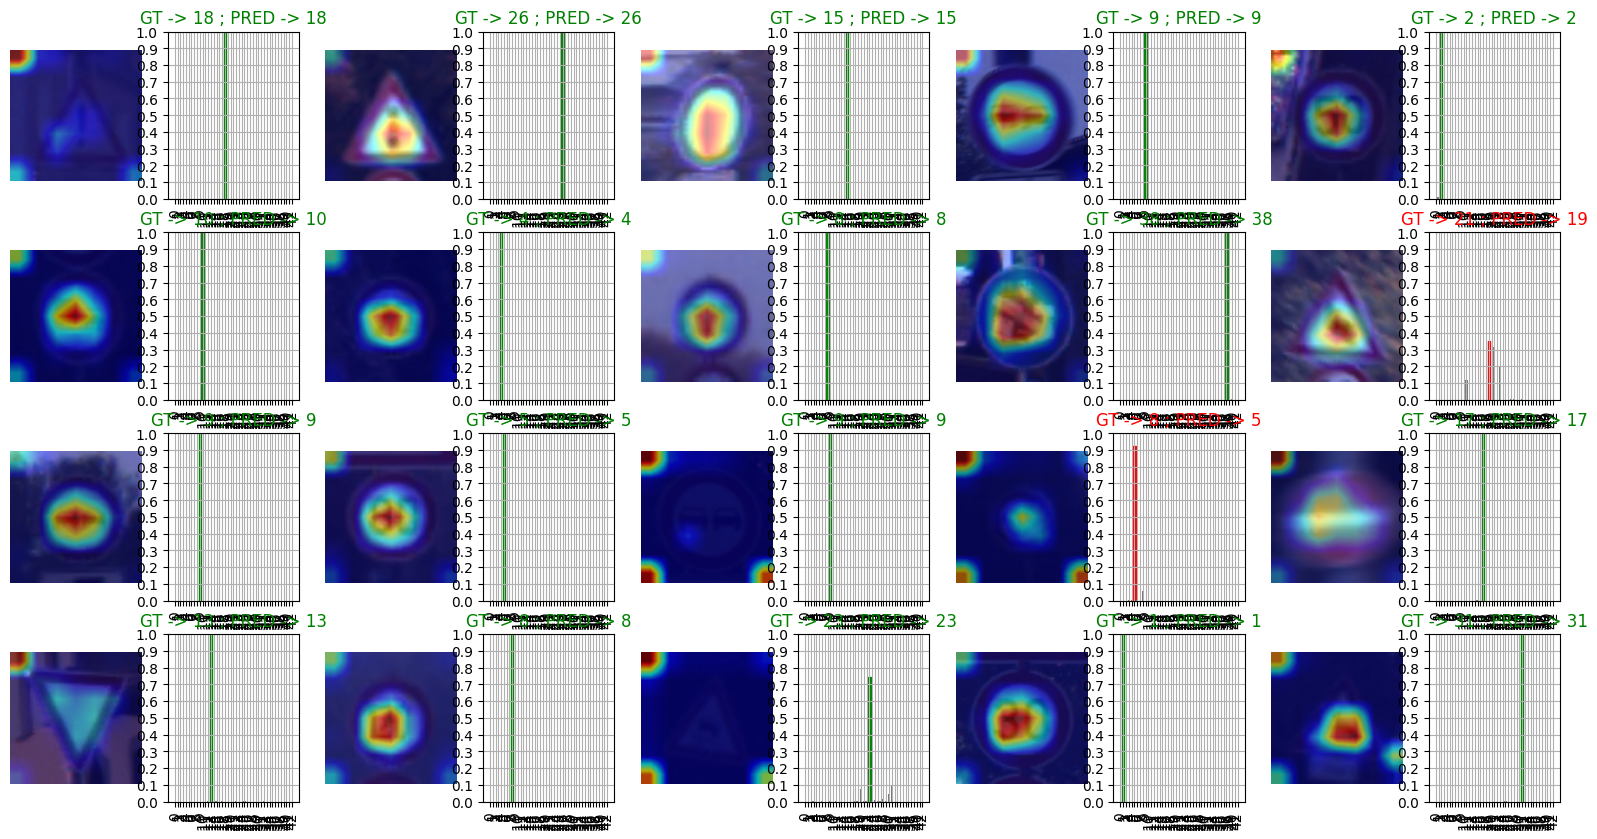

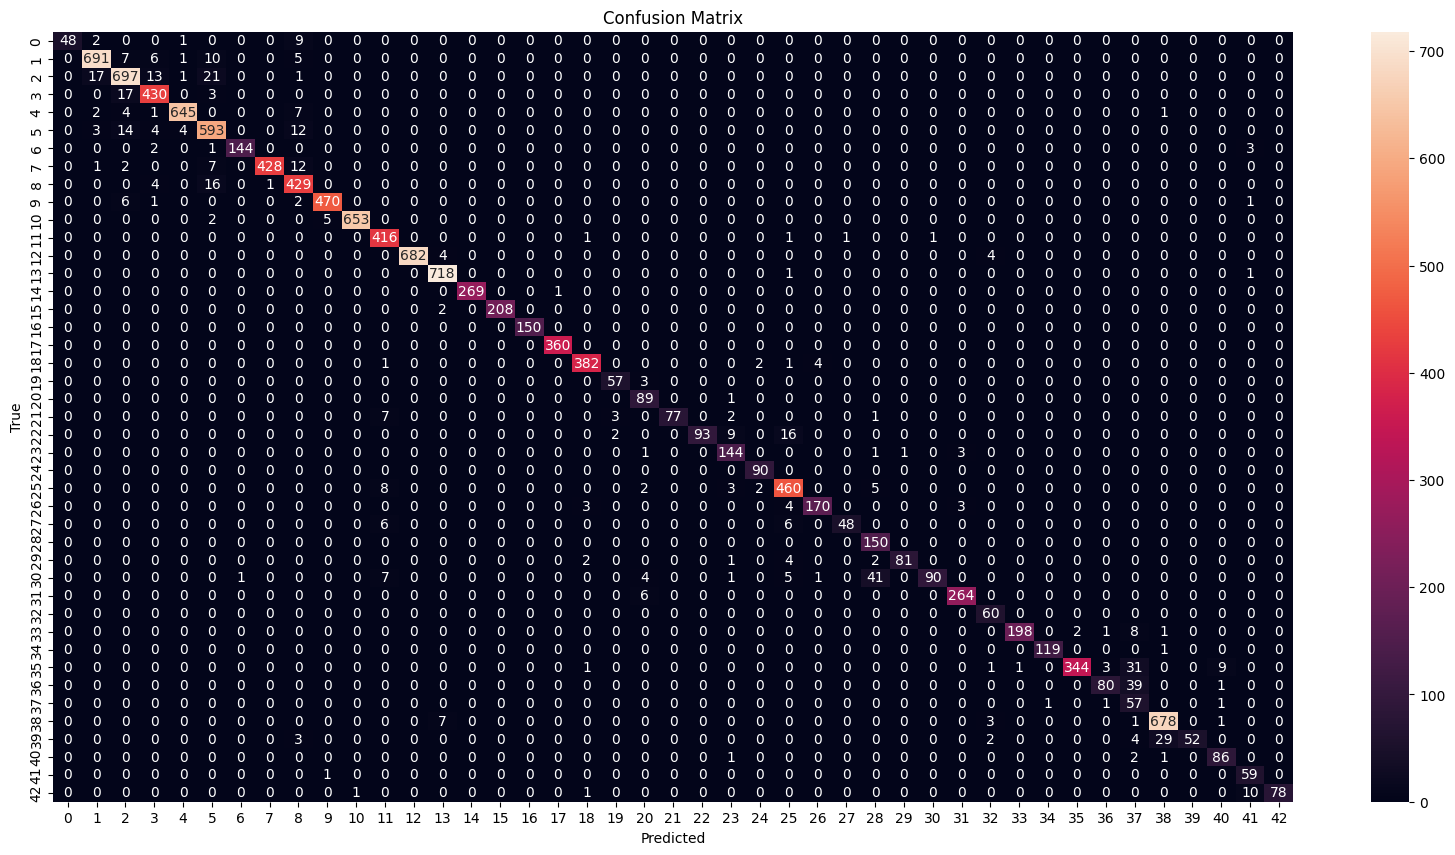

In [29]:
import cv2, random
import seaborn as sns
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

classes = class_names


class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Reverse the normalization applied to the image tensor.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

class ModelInferenceVisualizer:
    def __init__(self, model, device, class_names=None, im_size=224, mean = mean, std = std):

        self.denormalize = Denormalize(mean, std)
        self.model = model
        self.device = device
        self.class_names = class_names
        self.im_size = im_size
        self.model.eval()  # Set model to evaluation mode

    def tensor_to_image(self, tensor):
        """
        Convert a normalized tensor to a denormalized image array.
        """
        tensor = self.denormalize(tensor)  # Denormalize the tensor
        tensor = tensor.permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        return (tensor.cpu().numpy() * 255).astype(np.uint8)

    def plot_value_array(self, logits, gt, class_names):
        """Plot the prediction probability array."""
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1)

        plt.grid(visible=True)
        plt.xticks(range(len(class_names)), class_names, rotation='vertical')
        plt.yticks(np.arange(0.0, 1.1, 0.1))
        bars = plt.bar(range(len(class_names)), [p.item() for p in probs[0]], color="#777777")
        plt.ylim([0, 1])
        if pred_class.item() == gt:
            bars[pred_class].set_color('green')
        else:
            bars[pred_class].set_color('red')

    def generate_cam_visualization(self, image_tensor):
        """Generate GradCAM visualization."""
        cam = GradCAMPlusPlus(model=self.model, target_layers=[self.model.features[-1]]) # resnet50 -> self.model.layer4[-1]
        grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0))[0, :]  # 2D, [4, 256], [256]
        return grayscale_cam

    def infer_and_visualize(self, test_dl, num_images=5, rows=2):
        """Perform inference and visualize predictions along with GradCAM."""
        preds, images, lbls, logitss = [], [], [], []
        accuracy, count = 0, 1

        with torch.no_grad():
            for idx, batch in tqdm(enumerate(test_dl), desc="Inference"):
                # if idx == 2: break
                im, gt = TrainValidation.to_device(batch, device = self.device)
                # print(im.shape) # (bs, im_chs, im_h, im_w)
                # print(im[0].shape)
                logits = self.model(im)
                pred_class = torch.argmax(logits, dim=1)
                accuracy += (pred_class == gt).sum().item()
                images.append(im[0]) # (bs, im_chs, im_h, im_w) -> (im_chs, im_h, im_w)
                logitss.append(logits[0])
                preds.append(pred_class[0].item())
                lbls.append(gt[0].item())

        print(f"Accuracy of the model on the test data -> {(accuracy / len(test_dl.dataset)):.3f}")

        plt.figure(figsize=(20, 10))
        indices = [random.randint(0, len(images) - 1) for _ in range(num_images)]
        # 'num_images' ta rasm ichida for loop
        for idx, index in enumerate(indices):
            # Convert and denormalize image
            # print(images[index].shape)
            # rand = torch.rand(1, 3, 64, 64)
            # print(images[index].squeeze().shape)
            # print(f"rand.shape -> {rand.shape}")
            # print(f"rand.squeeze().shape -> {rand.squeeze().shape}")
            im = self.tensor_to_image(images[index]) # ()
            pred_idx = preds[index]
            gt_idx = lbls[index]

            # Display image
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            plt.imshow(im, cmap="gray")
            plt.axis("off")

            # GradCAM visualization
            grayscale_cam = self.generate_cam_visualization(images[index])
            visualization = show_cam_on_image(im / 255, grayscale_cam, image_weight=0.4, use_rgb=True)
            plt.imshow(cv2.resize(visualization, (self.im_size, self.im_size), interpolation=cv2.INTER_LINEAR), alpha=0.7, cmap='jet')
            plt.axis("off")

            # Prediction probability array
            logits = logitss[index]
            if logits.dim() == 1:  # If 1D, add a batch dimension
                logits = logits.unsqueeze(0)
            plt.subplot(rows, 2 * num_images // rows, count)
            count += 1
            self.plot_value_array(logits=logits, gt=gt_idx, class_names=self.class_names)

            # Title with GT and Prediction
            if self.class_names:
                gt_name = self.class_names[gt_idx]
                pred_name = self.class_names[pred_idx]
                color = "green" if gt_name == pred_name else "red"
                plt.title(f"GT -> {gt_name} ; PRED -> {pred_name}", color=color)

        # Plot confusion matrix
        plt.figure(figsize=(20, 10))
        cm = confusion_matrix(lbls, preds)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

model = timm.create_model(model_name = model_name, pretrained = True, num_classes = len(classes)).to(device)
model.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
inference_visualizer = ModelInferenceVisualizer(
    model=model,
    device=device,
    class_names=list(classes),  # List of class names
    im_size=im_size
)

inference_visualizer.infer_and_visualize(ts_dl, num_images = 20, rows = 4)